In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

/Users/nilsgrunefeld/Documents/GitHub/gradient-uncertainty/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
def compare_measures(m1, m2, name1, name2, ax=None):
    m1 = m1.flatten()
    m2 = m2.flatten()

    correlation = torch.corrcoef(torch.stack((m2, m1)))[0, 1]
    print(f"Correlation between {name1} and {name2}: {correlation.item():.4f}")

    if ax is not None:
        ax.scatter(m1, m2, alpha=0.5, s=5)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
        ax.set_title(f"Correlation: {correlation.item():.4f}")

        z = np.polyfit(m1.numpy(), m2.numpy(), 1)
        p = np.poly1d(z)
        x_range = np.linspace(m1.min().item(), m1.max().item(), 100)
        ax.plot(x_range, p(x_range), "r--", alpha=0.8)

    return correlation.item()

In [3]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.layer_1 = nn.Linear(2, num_classes)
        self.num_classes = num_classes

    def forward(self, x):
        logits = self.layer_1(x)
        return F.softmax(logits, dim=1)
    
    def get_logits(self, x):
        return self.layer_1(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [4]:
class ComplexModel(nn.Module):
    def __init__(self, hidden_size=32, num_classes=3):
        super().__init__()
        self.layer_1 = nn.Linear(2, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, num_classes)
        self.num_classes = num_classes

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        logits = self.layer_2(x)
        return F.softmax(logits, dim=1)
    
    def get_logits(self, x):
        x = F.relu(self.layer_1(x))
        return self.layer_2(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [5]:
def get_grad_norm(model, loss_fn, x, y):
    model.zero_grad()
    outputs = model(x)
    loss = loss_fn(outputs, y)
    loss.backward()

    grads = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())

    return torch.norm(torch.cat(grads))

In [ ]:
def get_grad_norm_grid(model, loss_fn, samples, original_preds=None, target_class=None):
    """Compute gradient norm for grid points.
    
    Args:
        model: The neural network model
        loss_fn: Loss function (e.g., nn.CrossEntropyLoss)
        samples: Grid points to evaluate
        original_preds: Original predictions if available (to avoid recomputation)
        target_class: Target class to use (if None, use predicted class)
        
    Returns:
        Tensor containing gradient norms for each sample
    """
    viz_grad = []

    for x in samples:
        x_tensor = x.reshape(1, -1)
        
        # Get predicted class if original_preds not provided
        if original_preds is None:
            with torch.no_grad():
                logits = model.get_logits(x_tensor)
                pred_class = logits.argmax(dim=1)
        else:
            pred_class = original_preds[x_tensor]
        
        # Use target_class if provided, otherwise use predicted class
        if target_class is not None:
            target = torch.tensor([target_class])
        else:
            target = pred_class
            
        # Compute gradient norm
        viz_grad.append(get_grad_norm(model, loss_fn, x_tensor, target))

    return torch.tensor(viz_grad)

In [21]:
def calculate_gradient_stats(grad_uncertainty_dict):
    """Calculate statistics from multiple gradient uncertainty measures.
    
    Args:
        grad_uncertainty_dict: Dictionary of gradient uncertainties for different class permutations
        
    Returns:
        Tuple of (average gradient uncertainty, standard deviation between uncertainties)
    """
    # Calculate average gradient uncertainty across all class permutations
    uncertainties = list(grad_uncertainty_dict.values())
    grad_avg = sum(uncertainties) / len(uncertainties)
    
    # Calculate standard deviation between different class permutations
    if len(uncertainties) > 1:
        # Stack all uncertainties into a tensor of shape [num_permutations, num_points]
        stacked = torch.stack(uncertainties)
        # Compute standard deviation along the permutation dimension
        grad_std = torch.std(stacked, dim=0)
    else:
        # If only one permutation, standard deviation is zero
        grad_std = torch.zeros_like(grad_avg)
    
    return grad_avg, grad_std

In [8]:
def model_to_pyro(model, X, y, prior_precision=0.01):
    """Convert PyTorch model to Pyro model for MCMC."""
    def model_fn():
        n_params = model.count_parameters()
        n_classes = model.num_classes

        # Set up priors on all parameters
        scale = 1.0 / np.sqrt(prior_precision)
        prior = dist.Normal(
            loc=torch.zeros(n_params), scale=scale * torch.ones(n_params)
        ).to_event(1)

        # Sample parameters from prior
        params = pyro.sample("params", prior)

        # Apply parameters to the model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = params[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Forward pass through the model
        with torch.no_grad():
            logits = model.get_logits(X)

        # Likelihood for multiclass
        with pyro.plate("data", len(X)):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return obs

    return model_fn

In [9]:
def run_mcmc_with_pyro(model, X, y, prior_precision=0.01, num_samples=1000, warmup_steps=200):
    """Run MCMC sampling for the model parameters."""
    pyro_model = model_to_pyro(model, X, y, prior_precision)

    # Pre-training with cross-entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    print("Pre-training model for MCMC initialization...")
    for epoch in range(100):
        logits = model.get_logits(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

    kernel = NUTS(pyro_model)

    print(f"Running NUTS MCMC sampler...")
    mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc.run()

    samples = mcmc.get_samples()

    return samples

In [10]:
def pyro_samples_to_matrix(samples):
    """Extract parameter samples from Pyro MCMC results."""
    param_samples = samples["params"]
    return param_samples

In [11]:
def mcmc_predict_with_samples(model, X_test, param_samples):
    """Make predictions using MCMC parameter samples."""
    n_samples = param_samples.shape[0]
    n_test = X_test.shape[0]
    n_classes = model.num_classes

    # Store predictions for each class from all samples
    all_preds = torch.zeros(n_samples, n_test, n_classes)

    # Make predictions for each sample
    for i in range(n_samples):
        # Extract parameters for this sample
        params = param_samples[i]

        # Apply parameters to model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = params[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Make predictions
        with torch.no_grad():
            preds = model(X_test)
            all_preds[i] = preds

    # Compute mean and variance
    # For multiclass, we compute mean and variance for each class probability
    pred_mean = all_preds.mean(dim=0)
    pred_var = all_preds.var(dim=0)
    
    # Total predictive uncertainty (sum of variances across all classes)
    total_uncertainty = pred_var.sum(dim=1)

    return pred_mean, pred_var, total_uncertainty

In [36]:
def plot_multiclass_decision_boundary_and_uncertainty(
    model, X, y, criterion, mcmc_samples=None, title_prefix=""
):
    """Plot decision boundary and uncertainty measures for multiclass classification."""
    # Create a grid for visualization
    x_min, x_max = X[:, 0].min() - 1.5, X[:, 0].max() + 1.5
    y_min, y_max = X[:, 1].min() - 1.5, X[:, 1].max() + 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Evaluate model on the grid
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    n_classes = model.num_classes
    
    # Get predictions on the grid
    with torch.no_grad():
        grid_probs = model(grid)
        grid_logits = model.get_logits(grid)
        grid_classes = grid_probs.argmax(dim=1).reshape(xx.shape)
    
    # MCMC predictions if samples are provided
    if mcmc_samples is not None:
        mcmc_mean, mcmc_var, mcmc_total_uncertainty = mcmc_predict_with_samples(model, grid, mcmc_samples)
        mcmc_total_uncertainty = mcmc_total_uncertainty.reshape(xx.shape)
    
    # Compute gradient uncertainties for both same and alternative labels
    # 1. Gradient uncertainty for same (predicted) label
    gradient_uncertainty_same = torch.zeros(len(grid))
    # 2. Gradient uncertainty for alternative labels (average)
    gradient_uncertainty_alt = torch.zeros(len(grid))
    
    # Compute for each grid point
    for i, x in enumerate(grid):
        x_tensor = x.reshape(1, -1)
        with torch.no_grad():
            probs = model(x_tensor)
            pred_class = probs.argmax(dim=1).item()
        
        # Gradient norm for predicted class
        target_same = torch.tensor([pred_class])
        grad_norm_same = get_grad_norm(model, criterion, x_tensor, target_same)
        gradient_uncertainty_same[i] = grad_norm_same
        
        # Average gradient norm for alternative classes
        alt_grads = []
        for j in range(n_classes):
            if j != pred_class:  # Only for alternative classes
                target_alt = torch.tensor([j])
                grad_norm_alt = get_grad_norm(model, criterion, x_tensor, target_alt)
                alt_grads.append(grad_norm_alt)
        
        if alt_grads:  # If there are alternative classes
            gradient_uncertainty_alt[i] = sum(alt_grads) / len(alt_grads)
    
    # Reshape for visualization
    gradient_uncertainty_same = gradient_uncertainty_same.reshape(xx.shape)
    gradient_uncertainty_alt = gradient_uncertainty_alt.reshape(xx.shape)
    
    # Calculate combined measures
    grad_avg = (gradient_uncertainty_same + gradient_uncertainty_alt) / 2.0
    grad_std = torch.abs(gradient_uncertainty_same - gradient_uncertainty_alt) / (torch.sqrt(torch.tensor(2.0)))
    
    # Plotting
    plt.figure(figsize=(30, 6))  # Increase width for more space
    if mcmc_samples is not None:
        n_plots = 6
    else:
        n_plots = 5
    
    # Plot decision boundary
    plt.subplot(1, n_plots, 1)
    plt.contourf(xx, yy, grid_classes.numpy(), alpha=0.8, cmap=plt.cm.tab10, 
                 levels=np.arange(n_classes+1)-0.5)
    plt.colorbar(ticks=range(n_classes), label="Class")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
    plt.title(f"{title_prefix}\nDecision Boundary")  # Add newline in title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    # Plot gradient uncertainty (same label)
    plt.subplot(1, n_plots, 2)
    plt.contourf(xx, yy, gradient_uncertainty_same.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Gradient Norm (Same)")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
    plt.title(f"{title_prefix}\nGradient Uncertainty (Same)")  # Add newline in title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    # Plot gradient uncertainty (alternative labels)
    plt.subplot(1, n_plots, 3)
    plt.contourf(xx, yy, gradient_uncertainty_alt.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Gradient Norm (Alt)")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
    plt.title(f"{title_prefix}\nGradient Uncertainty (Alt)")  # Add newline in title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    # Plot average gradient uncertainty
    plt.subplot(1, n_plots, 4)
    plt.contourf(xx, yy, grad_avg.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Average Gradient Norm")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
    plt.title(f"{title_prefix}\nAverage Gradient Uncertainty")  # Add newline in title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    # Plot std between gradient uncertainties
    plt.subplot(1, n_plots, 5)
    plt.contourf(xx, yy, grad_std.numpy(), alpha=0.8, cmap="viridis")
    plt.colorbar(label="Standard Deviation")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
    plt.title(f"{title_prefix}\nStd Between Gradient Uncertainties")  # Add newline in title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    # Plot MCMC uncertainty if available
    if mcmc_samples is not None:
        plt.subplot(1, n_plots, 6)
        plt.contourf(xx, yy, mcmc_total_uncertainty.numpy(), alpha=0.8, cmap="viridis")
        plt.colorbar(label="MCMC Uncertainty")
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
        plt.title(f"{title_prefix}\nMCMC Uncertainty")  # Add newline in title
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        
        # Additional plots comparing MCMC with gradient measures
        plt.figure(figsize=(20, 5))
        plt.subplots_adjust(wspace=0.3)  # Add space between subplots
        
        ax1 = plt.subplot(1, 4, 1)
        compare_measures(mcmc_total_uncertainty, gradient_uncertainty_same, "MCMC Uncertainty", "Gradient (Same)", ax1)
        ax2 = plt.subplot(1, 4, 2)
        compare_measures(mcmc_total_uncertainty, gradient_uncertainty_alt, "MCMC Uncertainty", "Gradient (Alt)", ax2)
        ax3 = plt.subplot(1, 4, 3)
        compare_measures(mcmc_total_uncertainty, grad_avg, "MCMC Uncertainty", "Gradient (Avg)", ax3)
        ax4 = plt.subplot(1, 4, 4)
        compare_measures(mcmc_total_uncertainty, grad_std, "MCMC Uncertainty", "Gradient (Std)", ax4)
        plt.tight_layout()
        plt.show()
    
    plt.tight_layout(pad=3.0)  # Increase padding around subplots
    plt.show()
    
    # Print summary statistics
    print(f"Average gradient uncertainty (same label): {gradient_uncertainty_same.mean().item():.4f}")
    print(f"Average gradient uncertainty (alt labels): {gradient_uncertainty_alt.mean().item():.4f}")
    print(f"Average of gradient uncertainties: {grad_avg.mean().item():.4f}")
    print(f"Average std between gradient uncertainties: {grad_std.mean().item():.4f}")
    
    if mcmc_samples is not None:
        print(f"Average MCMC uncertainty: {mcmc_total_uncertainty.mean().item():.4f}")
        corr_mcmc_grad_same = compare_measures(mcmc_total_uncertainty, gradient_uncertainty_same, "MCMC", "Gradient (Same)", None)
        corr_mcmc_grad_alt = compare_measures(mcmc_total_uncertainty, gradient_uncertainty_alt, "MCMC", "Gradient (Alt)", None)
        corr_mcmc_grad_avg = compare_measures(mcmc_total_uncertainty, grad_avg, "MCMC", "Gradient (Avg)", None)
        corr_mcmc_grad_std = compare_measures(mcmc_total_uncertainty, grad_std, "MCMC", "Gradient (Std)", None)
        
        return {
            "grad_same": gradient_uncertainty_same,
            "grad_alt": gradient_uncertainty_alt,
            "grad_avg": grad_avg,
            "grad_std": grad_std,
            "mcmc": mcmc_total_uncertainty,
            "corr_mcmc_grad_same": corr_mcmc_grad_same,
            "corr_mcmc_grad_alt": corr_mcmc_grad_alt,
            "corr_mcmc_grad_avg": corr_mcmc_grad_avg,
            "corr_mcmc_grad_std": corr_mcmc_grad_std
        }
    else:
        return {
            "grad_same": gradient_uncertainty_same,
            "grad_alt": gradient_uncertainty_alt,
            "grad_avg": grad_avg,
            "grad_std": grad_std
        }


In [37]:
def run_experiment(
    X,
    y,
    model_class,
    model_args=None,
    train_method="adam",
    epochs=1000,
    title_prefix="",
    verbose=True,
):
    """Run a standard training experiment and compute uncertainty measures."""
    if model_args is None:
        model_args = {}
    
    # Convert to PyTorch tensors
    X = torch.Tensor(X)
    y_numpy = y.astype(np.int64)  # Ensure y is integer for class indices
    y = torch.LongTensor(y_numpy)
    
    # Create and train the model
    model = model_class(**model_args)
    criterion = nn.CrossEntropyLoss()
    
    if train_method == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        for epoch in range(epochs):
            # Forward pass
            logits = model.get_logits(X)
            loss = criterion(logits, y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose and (epoch + 1) % (epochs // 10) == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    # Evaluate accuracy
    with torch.no_grad():
        logits = model.get_logits(X)
        _, predicted = torch.max(logits, 1)
        accuracy = (predicted == y).float().mean()
    
    if verbose:
        print(f"Accuracy on entire dataset: {accuracy.item():.4f}")
    
    # Calculate and visualize uncertainty
    uncertainty_results = plot_multiclass_decision_boundary_and_uncertainty(
        model, X, y, criterion, mcmc_samples=None, title_prefix=title_prefix
    )
    
    return model, accuracy.item(), uncertainty_results


In [38]:
def run_mcmc_experiment(
    X,
    y,
    model_class,
    model_args=None,
    prior_precision=0.01,
    num_samples=1000,
    warmup_steps=200,
    title_prefix="",
    verbose=True,
):
    """Run an MCMC experiment and compute uncertainty measures."""
    if model_args is None:
        model_args = {}
    
    # Convert to PyTorch tensors
    X = torch.Tensor(X)
    y_numpy = y.astype(np.int64)  # Ensure y is integer for class indices
    y = torch.LongTensor(y_numpy)
    
    # Create model and run MCMC
    model = model_class(**model_args)
    criterion = nn.CrossEntropyLoss()
    
    samples = run_mcmc_with_pyro(
        model,
        X,
        y,
        prior_precision=prior_precision,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
    )
    
    param_samples = pyro_samples_to_matrix(samples)
    
    # Calculate accuracy using mean of posterior samples
    with torch.no_grad():
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = param_samples.mean(dim=0)[idx : idx + param_size].reshape(
                param.shape
            )
            idx += param_size
        
        logits = model.get_logits(X)
        _, predicted = torch.max(logits, 1)
        accuracy = (predicted == y).float().mean()
    
    if verbose:
        print(f"Accuracy on entire dataset: {accuracy.item():.4f}")
    
    # Calculate and visualize uncertainty
    uncertainty_results = plot_multiclass_decision_boundary_and_uncertainty(
        model, X, y, criterion, mcmc_samples=param_samples, title_prefix=title_prefix
    )
    
    return model, accuracy.item(), uncertainty_results


Experiment 1: Linear multiclass blobs with a simple model (Adam training)
Epoch [20/200], Loss: 0.1101
Epoch [40/200], Loss: 0.0399
Epoch [60/200], Loss: 0.0237
Epoch [80/200], Loss: 0.0171
Epoch [100/200], Loss: 0.0133
Epoch [120/200], Loss: 0.0108
Epoch [140/200], Loss: 0.0090
Epoch [160/200], Loss: 0.0077
Epoch [180/200], Loss: 0.0067
Epoch [200/200], Loss: 0.0059
Accuracy on entire dataset: 1.0000


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_49028/1620834627.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


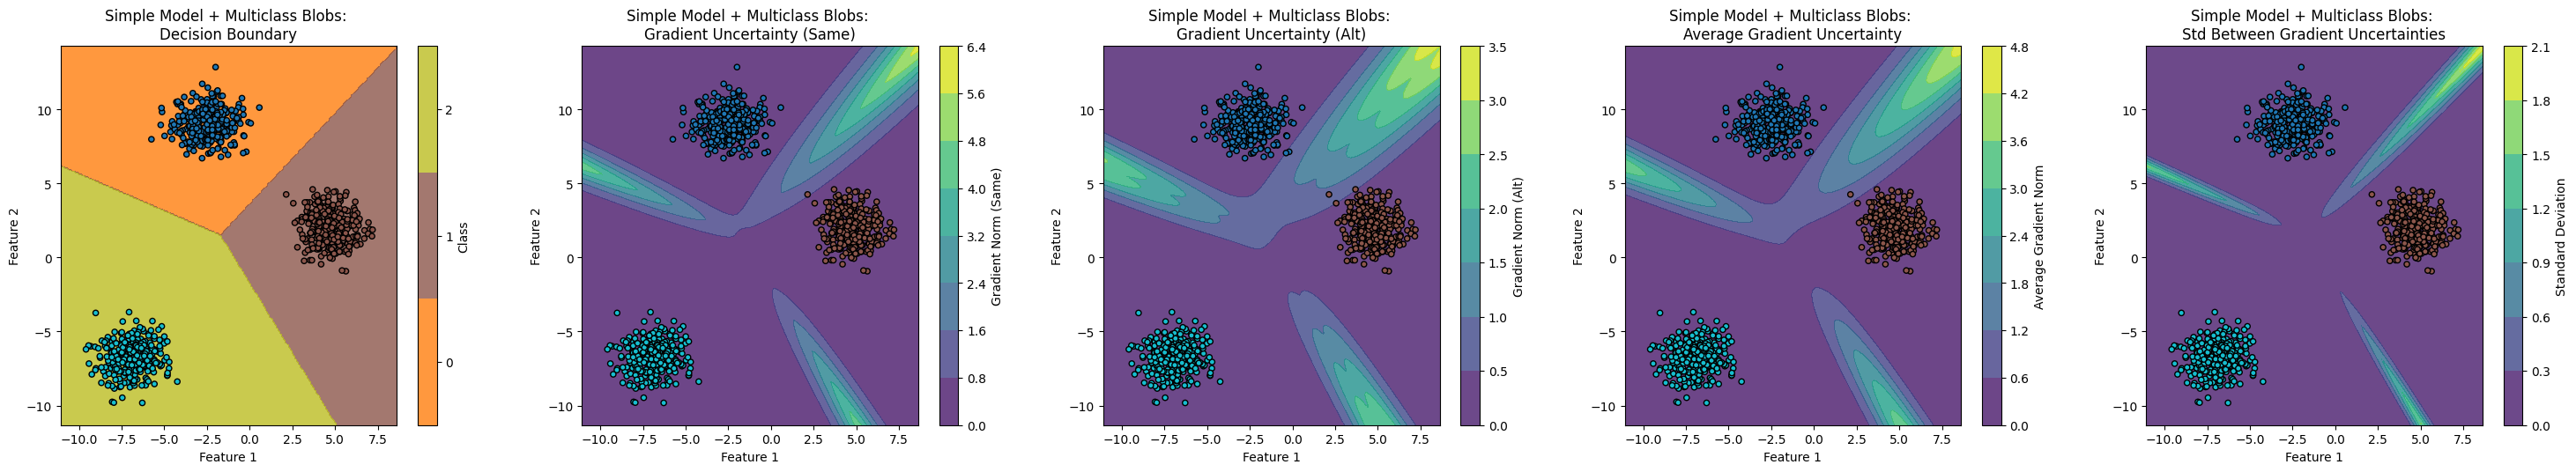

Average gradient uncertainty (same label): 0.4821
Average gradient uncertainty (alt labels): 0.4036
Average of gradient uncertainties: 0.4429
Average std between gradient uncertainties: 0.0853


In [39]:
# Experiment 1: Linearly separable multiclass blobs with a simple model
print("Experiment 1: Linear multiclass blobs with a simple model (Adam training)")
X_blobs, y_blobs = make_blobs(
    n_samples=1000, centers=3, n_features=2, cluster_std=1.0, random_state=42
)
num_classes = len(np.unique(y_blobs))

simple_model, simple_acc, simple_results = run_experiment(
    X_blobs,
    y_blobs,
    SimpleModel,
    {"num_classes": num_classes},
    epochs=200,
    train_method="adam",
    title_prefix="Simple Model + Multiclass Blobs: ",
)


Experiment 2: Nonlinear multiclass classification with a complex model
Epoch [50/500], Loss: 0.2740
Epoch [100/500], Loss: 0.2260
Epoch [150/500], Loss: 0.2002
Epoch [200/500], Loss: 0.1885
Epoch [250/500], Loss: 0.1814
Epoch [300/500], Loss: 0.1759
Epoch [350/500], Loss: 0.1717
Epoch [400/500], Loss: 0.1686
Epoch [450/500], Loss: 0.1662
Epoch [500/500], Loss: 0.1647
Accuracy on entire dataset: 0.9220


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_49028/1620834627.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


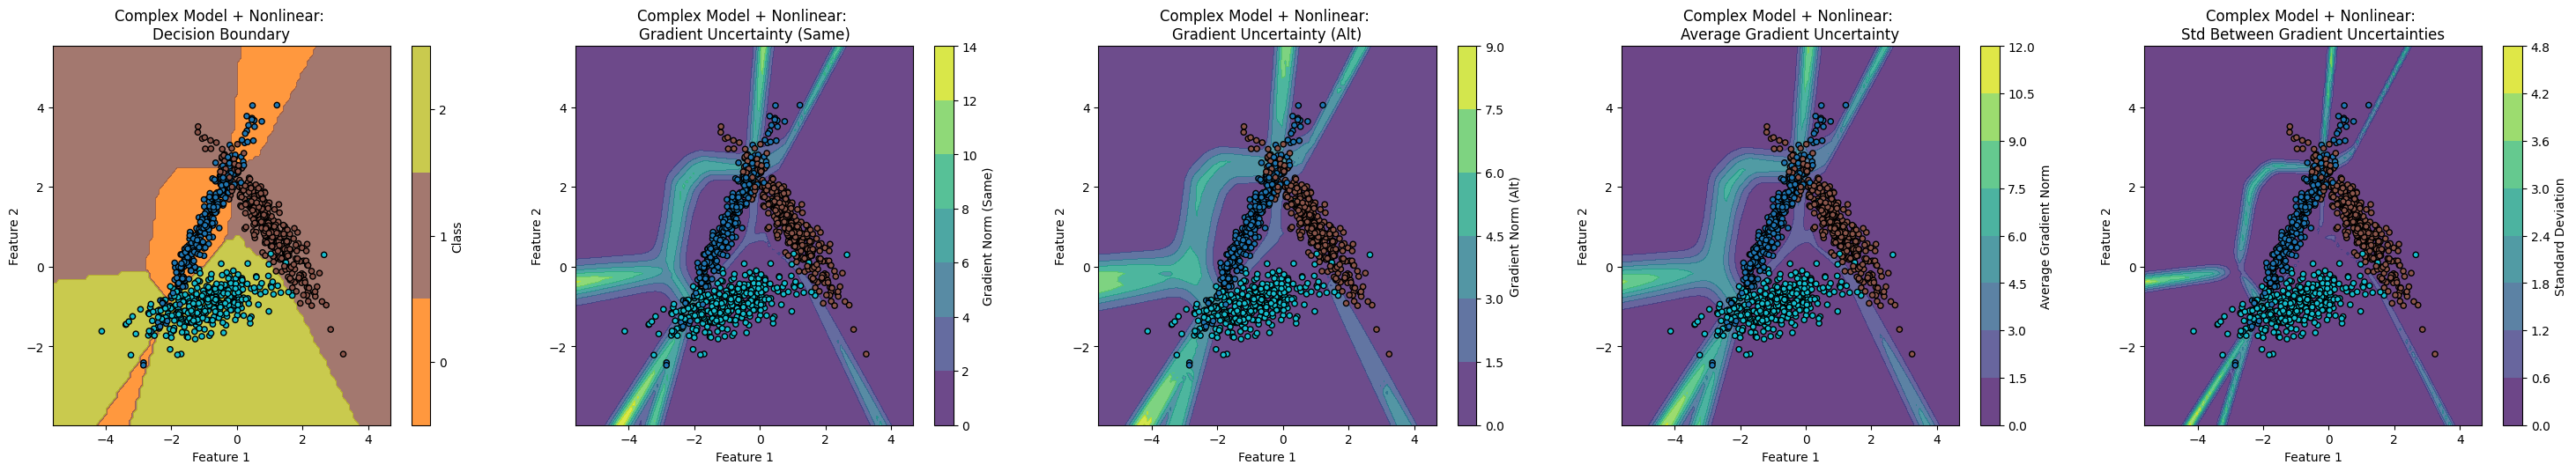

Average gradient uncertainty (same label): 1.0137
Average gradient uncertainty (alt labels): 0.8519
Average of gradient uncertainties: 0.9328
Average std between gradient uncertainties: 0.1770


In [40]:
# Experiment 2: Nonlinear multiclass classification with a complex model
print("\nExperiment 2: Nonlinear multiclass classification with a complex model")
X_nonlinear, y_nonlinear = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    n_classes=3, n_clusters_per_class=1, random_state=42
)
num_classes = len(np.unique(y_nonlinear))

complex_model, complex_acc, complex_results = run_experiment(
    X_nonlinear,
    y_nonlinear,
    ComplexModel,
    {"hidden_size": 32, "num_classes": num_classes},
    epochs=500,
    title_prefix="Complex Model + Nonlinear: ",
)


=== Experiment 3: Multiclass blobs dataset with simple model (MCMC) ===
Pre-training model for MCMC initialization...
Epoch [20/100], Loss: 3.2688
Epoch [40/100], Loss: 1.0203
Epoch [60/100], Loss: 0.2999
Epoch [80/100], Loss: 0.1488
Epoch [100/100], Loss: 0.0988
Running NUTS MCMC sampler...


Warmup:   0%|          | 0/600 [00:00, ?it/s]

Sample: 100%|██████████| 600/600 [05:17,  1.89it/s, step size=1.59e-03, acc. prob=0.965]
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_49028/1620834627.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Accuracy on entire dataset: 1.0000
Correlation between MCMC Uncertainty and Gradient (Same): 0.4282
Correlation between MCMC Uncertainty and Gradient (Alt): 0.4742
Correlation between MCMC Uncertainty and Gradient (Avg): 0.4514
Correlation between MCMC Uncertainty and Gradient (Std): 0.3265


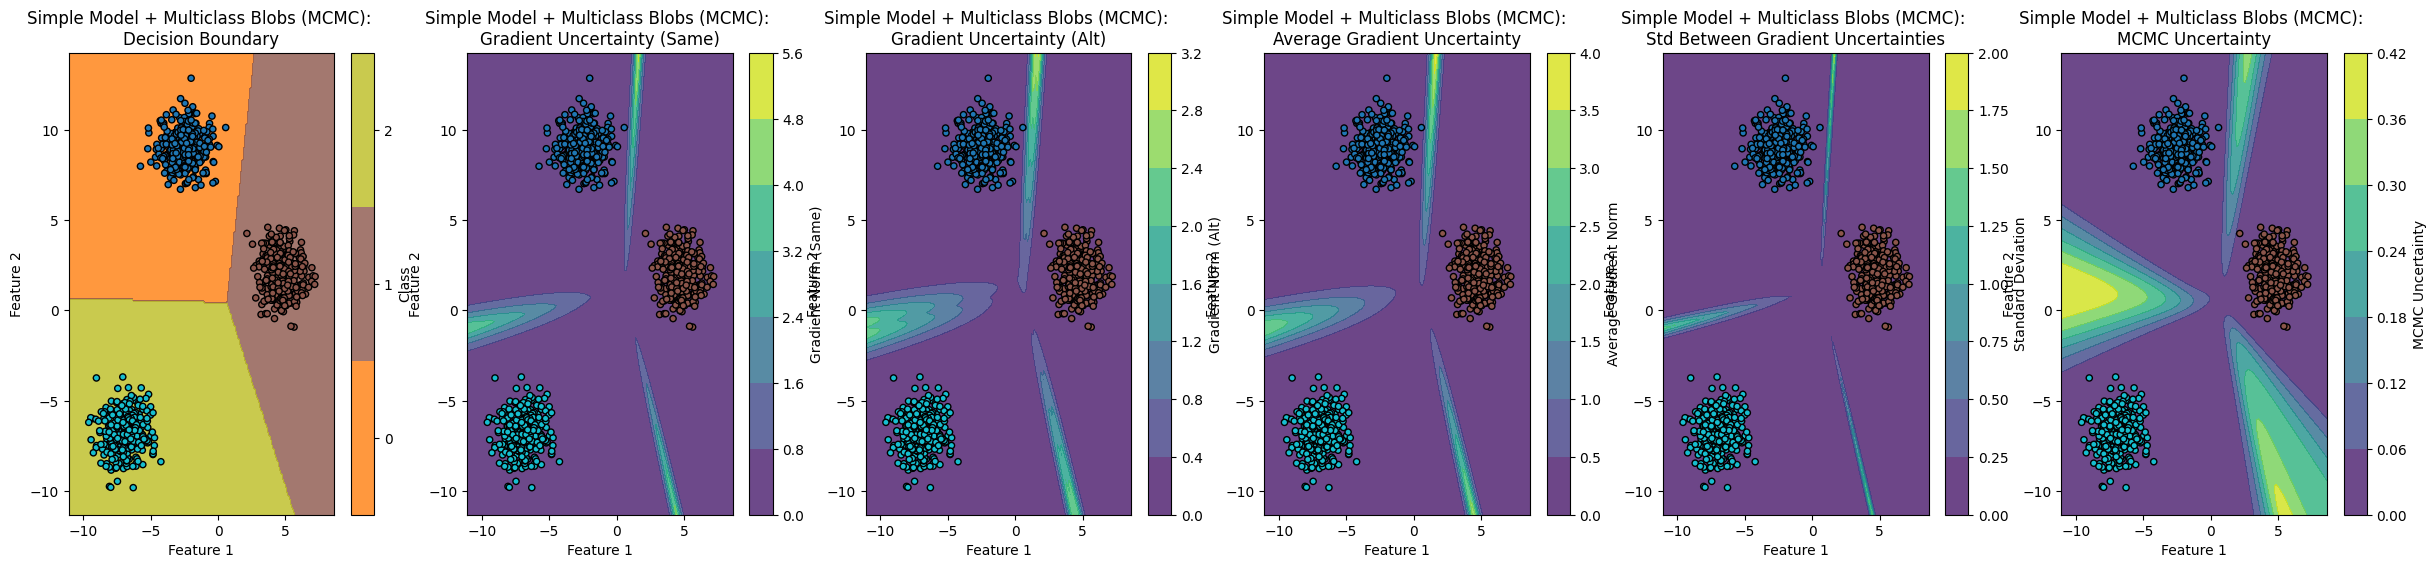

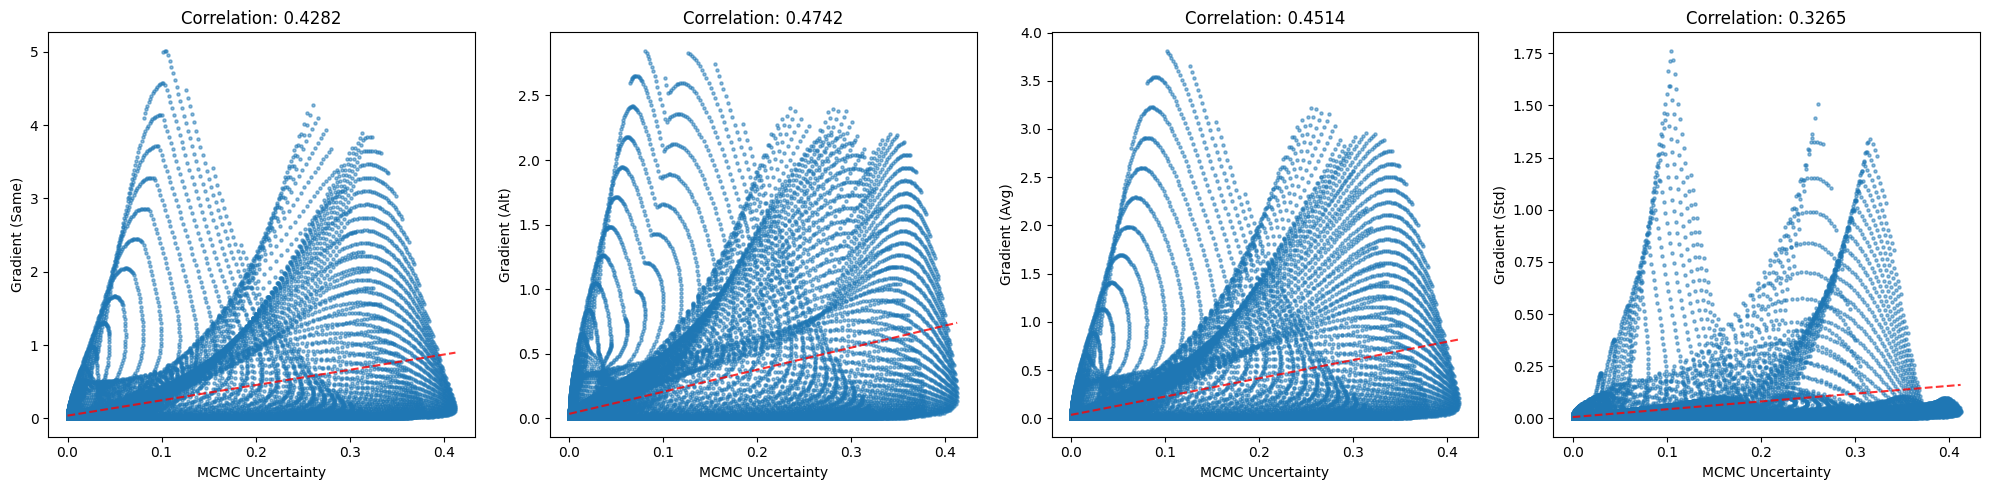

<Figure size 640x480 with 0 Axes>

Average gradient uncertainty (same label): 0.1567
Average gradient uncertainty (alt labels): 0.1330
Average of gradient uncertainties: 0.1449
Average std between gradient uncertainties: 0.0275
Average MCMC uncertainty: 0.0574
Correlation between MCMC and Gradient (Same): 0.4282
Correlation between MCMC and Gradient (Alt): 0.4742
Correlation between MCMC and Gradient (Avg): 0.4514
Correlation between MCMC and Gradient (Std): 0.3265


In [41]:
# Experiment 3: MCMC on multiclass blobs with simple model
print("\n=== Experiment 3: Multiclass blobs dataset with simple model (MCMC) ===")
mcmc_simple_model, mcmc_simple_acc, mcmc_simple_results = run_mcmc_experiment(
    X_blobs,
    y_blobs,
    SimpleModel,
    {"num_classes": num_classes},
    prior_precision=0.01,
    num_samples=500,
    warmup_steps=100,
    title_prefix="Simple Model + Multiclass Blobs (MCMC): ",
)


=== Experiment 4: Nonlinear multiclass dataset with complex model (MCMC) ===
Pre-training model for MCMC initialization...
Epoch [20/100], Loss: 0.4185
Epoch [40/100], Loss: 0.3033
Epoch [60/100], Loss: 0.2745
Epoch [80/100], Loss: 0.2603
Epoch [100/100], Loss: 0.2495
Running NUTS MCMC sampler...


Sample: 100%|██████████| 600/600 [06:54,  1.45it/s, step size=1.47e-03, acc. prob=0.641]
/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_49028/1620834627.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Accuracy on entire dataset: 0.8700
Correlation between MCMC Uncertainty and Gradient (Same): 0.5055
Correlation between MCMC Uncertainty and Gradient (Alt): 0.5339
Correlation between MCMC Uncertainty and Gradient (Avg): 0.5222
Correlation between MCMC Uncertainty and Gradient (Std): 0.3656


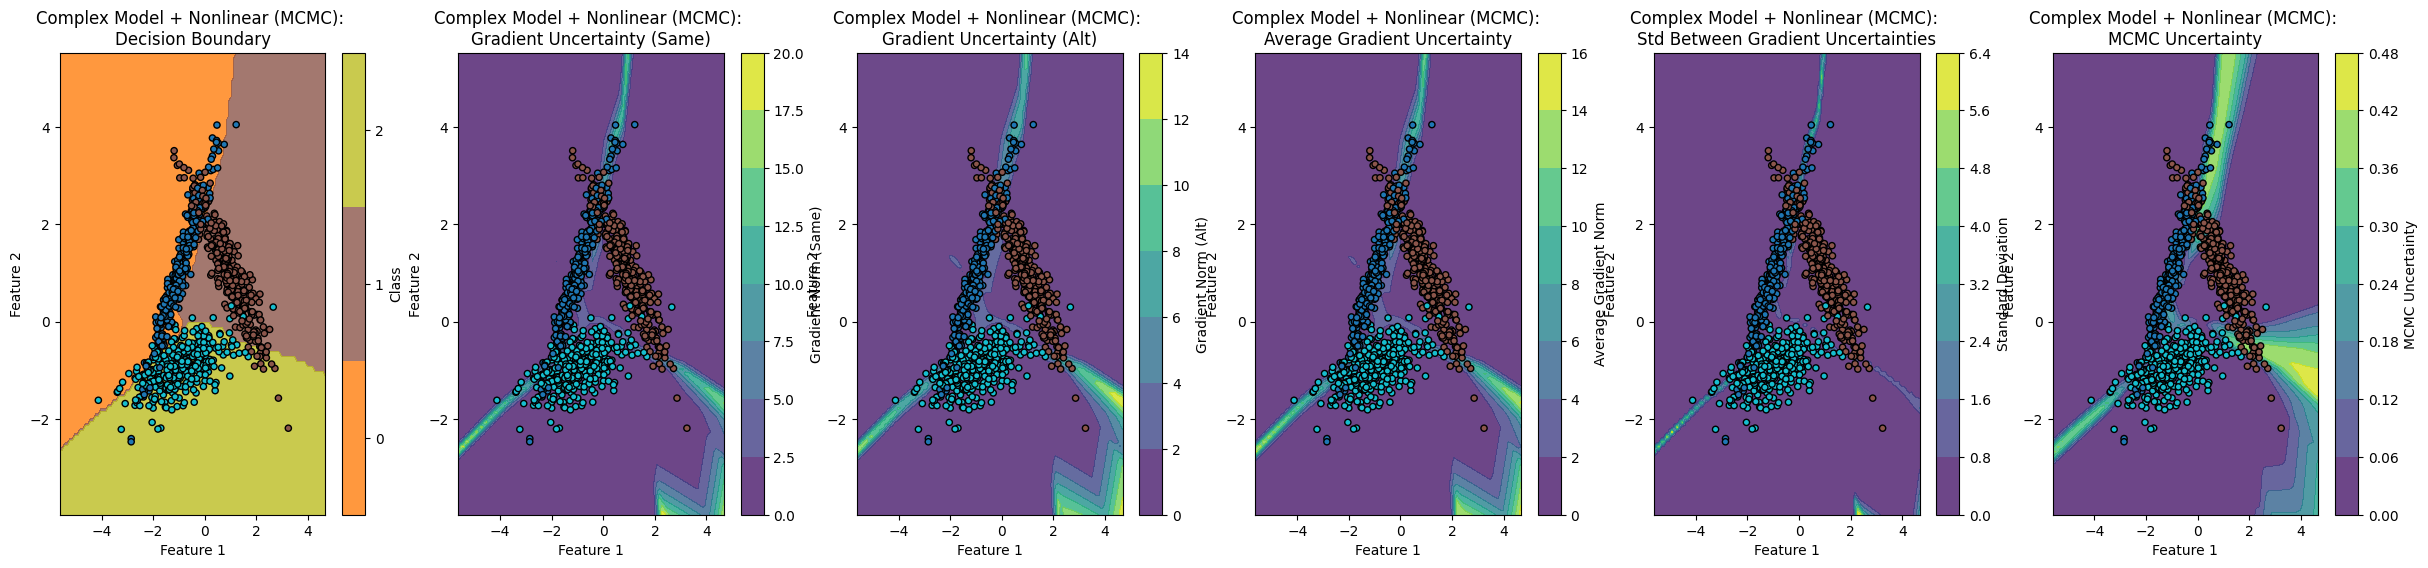

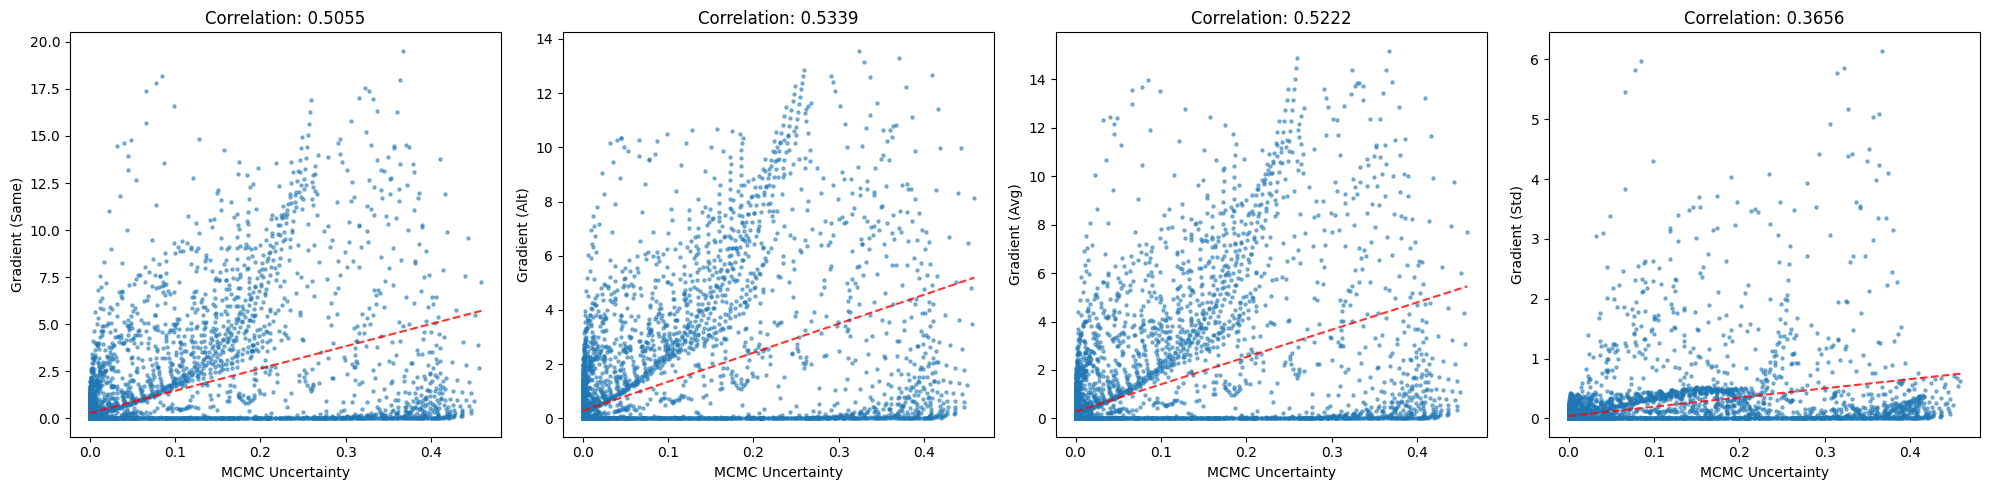

<Figure size 640x480 with 0 Axes>

Average gradient uncertainty (same label): 0.7343
Average gradient uncertainty (alt labels): 0.6929
Average of gradient uncertainties: 0.7136
Average std between gradient uncertainties: 0.1000
Average MCMC uncertainty: 0.0387
Correlation between MCMC and Gradient (Same): 0.5055
Correlation between MCMC and Gradient (Alt): 0.5339
Correlation between MCMC and Gradient (Avg): 0.5222
Correlation between MCMC and Gradient (Std): 0.3656


In [42]:
# Experiment 4: MCMC on nonlinear multiclass dataset with complex model
print("\n=== Experiment 4: Nonlinear multiclass dataset with complex model (MCMC) ===")
mcmc_complex_model, mcmc_complex_acc, mcmc_complex_results = run_mcmc_experiment(
    X_nonlinear,
    y_nonlinear,
    ComplexModel,
    {"hidden_size": 32, "num_classes": num_classes},
    prior_precision=0.001,
    num_samples=500,
    warmup_steps=100,
    title_prefix="Complex Model + Nonlinear (MCMC): ",
)